In [79]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

1 - Eliminar los datos nulos antes de dividir el dataset (train_test_split). Solo y_train? o todo el dataset. solo en en mi variable target 

Post train_test_split:

analisis descriptivo - evidenciar valores atipicos boxplot --- scatterplot --- realizar scatterplot bi-variado. ej: distancia vs precio (detectar outliers)

2 - Graficos post división

---- Supuesto de normalidad QQplot para poder realizar regresión en variable target? p-value < 0.05. ?  

heatmap para ver cuales variables prectoras esta correlacionado ( reducción de dim ) -> lo hacemos con X_train

3 - Outliers -> trabajar solo X_train. Diferenciar valores raros (imputo mediana) o errores(elimino). 3 desvios estandar-prob z-score(por fuera considerar outlier)

4 - Faltantes -> muy pocos (elimino) -> nuestro caso - Justificar : muy poco < 3-5% (calcular porcentaje representativo )



In [80]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [81]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [82]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


### 1 - Eliminación de datos faltantes en mi variable Target


In [84]:
# Eliminar datos faltantes en mi variable target si es que las hay para evitar desvalance de los datos post división

print(df['fare_amount'].isna().sum())


0


In [99]:
# chequeamos si existen valores menores o iguales a cero ya que estos serían errores

print((df['fare_amount'] <= 0).sum())

22


In [100]:
for i in df['fare_amount']:
    if i <= 0:
        print(i)

0.0
0.0
-5.0
-3.3
-3.5
0.0
-49.57
-23.7
-52.0
-7.3
-52.0
-6.9
-5.7
-3.0
-10.9
0.0
-3.5
-50.5
-3.5
-3.0
-5.5
0.0


In [102]:
porcentaje_error = (df['fare_amount'] <= 0).sum() / len(df) * 100

print(f"Porcentaje de error en variable target: {porcentaje_error}")


Porcentaje de error en variable target: 0.011000000000000001


In [ ]:
# Ya que el porcentaje es muy bajo decidimos eliminar esas filas

df_mod = df.drop(df[df['fare_amount'] <= 0])

KeyError: "['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'd_haversine', 'month', 'days_of_week', 'hour'] not found in axis"

### 2 - Creación de features de interes

#### Calculo de la distancia de Haversine

In [86]:
import numpy as np

# Radio de la Tierra en kilómetros
R = 6371  

# convertimos a radianes
df['pickup_latitude'] = np.radians(df['pickup_latitude'])
df['pickup_longitude'] = np.radians(df['pickup_longitude'])
df['dropoff_latitude'] = np.radians(df['dropoff_latitude'])
df['dropoff_longitude'] = np.radians(df['dropoff_longitude'])

# Realizamos la diferencia entre los radianes
delta_lat = df['dropoff_latitude'] - df['pickup_latitude']
delta_lon = df['dropoff_longitude'] - df['pickup_longitude']

# fórmula de Haversine
df['d_haversine'] = 2 * R * np.arcsin(np.sqrt(
    np.sin(delta_lat  / 2) ** 2 +
    np.cos(df['pickup_latitude']) * np.cos(df['dropoff_latitude']) *
    np.sin(delta_lon / 2) ** 2
))

# Unidad en kilometros

df['d_haversine'].head(3)

0    1.683323
1    2.457590
2    5.036377
Name: d_haversine, dtype: float64

#### Tratamiento fecha. Obtención de nuevas características

In [87]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['month'] = df['pickup_datetime'].dt.month
df['days_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour 

### 3 - División del conjunto de datos

In [88]:
# Dividimos 

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

### 4 - EDA (Análisis exploratorio de los datos)

In [89]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 160000 entries, 153248 to 121958
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                160000 non-null  int64              
 1   date               160000 non-null  object             
 2   pickup_datetime    160000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   160000 non-null  float64            
 4   pickup_latitude    160000 non-null  float64            
 5   dropoff_longitude  159999 non-null  float64            
 6   dropoff_latitude   159999 non-null  float64            
 7   passenger_count    160000 non-null  int64              
 8   d_haversine        159999 non-null  float64            
 9   month              160000 non-null  int32              
 10  days_of_week       160000 non-null  int32              
 11  hour               160000 non-null  int32              
dtypes: datetime64[ns, UTC](1), flo

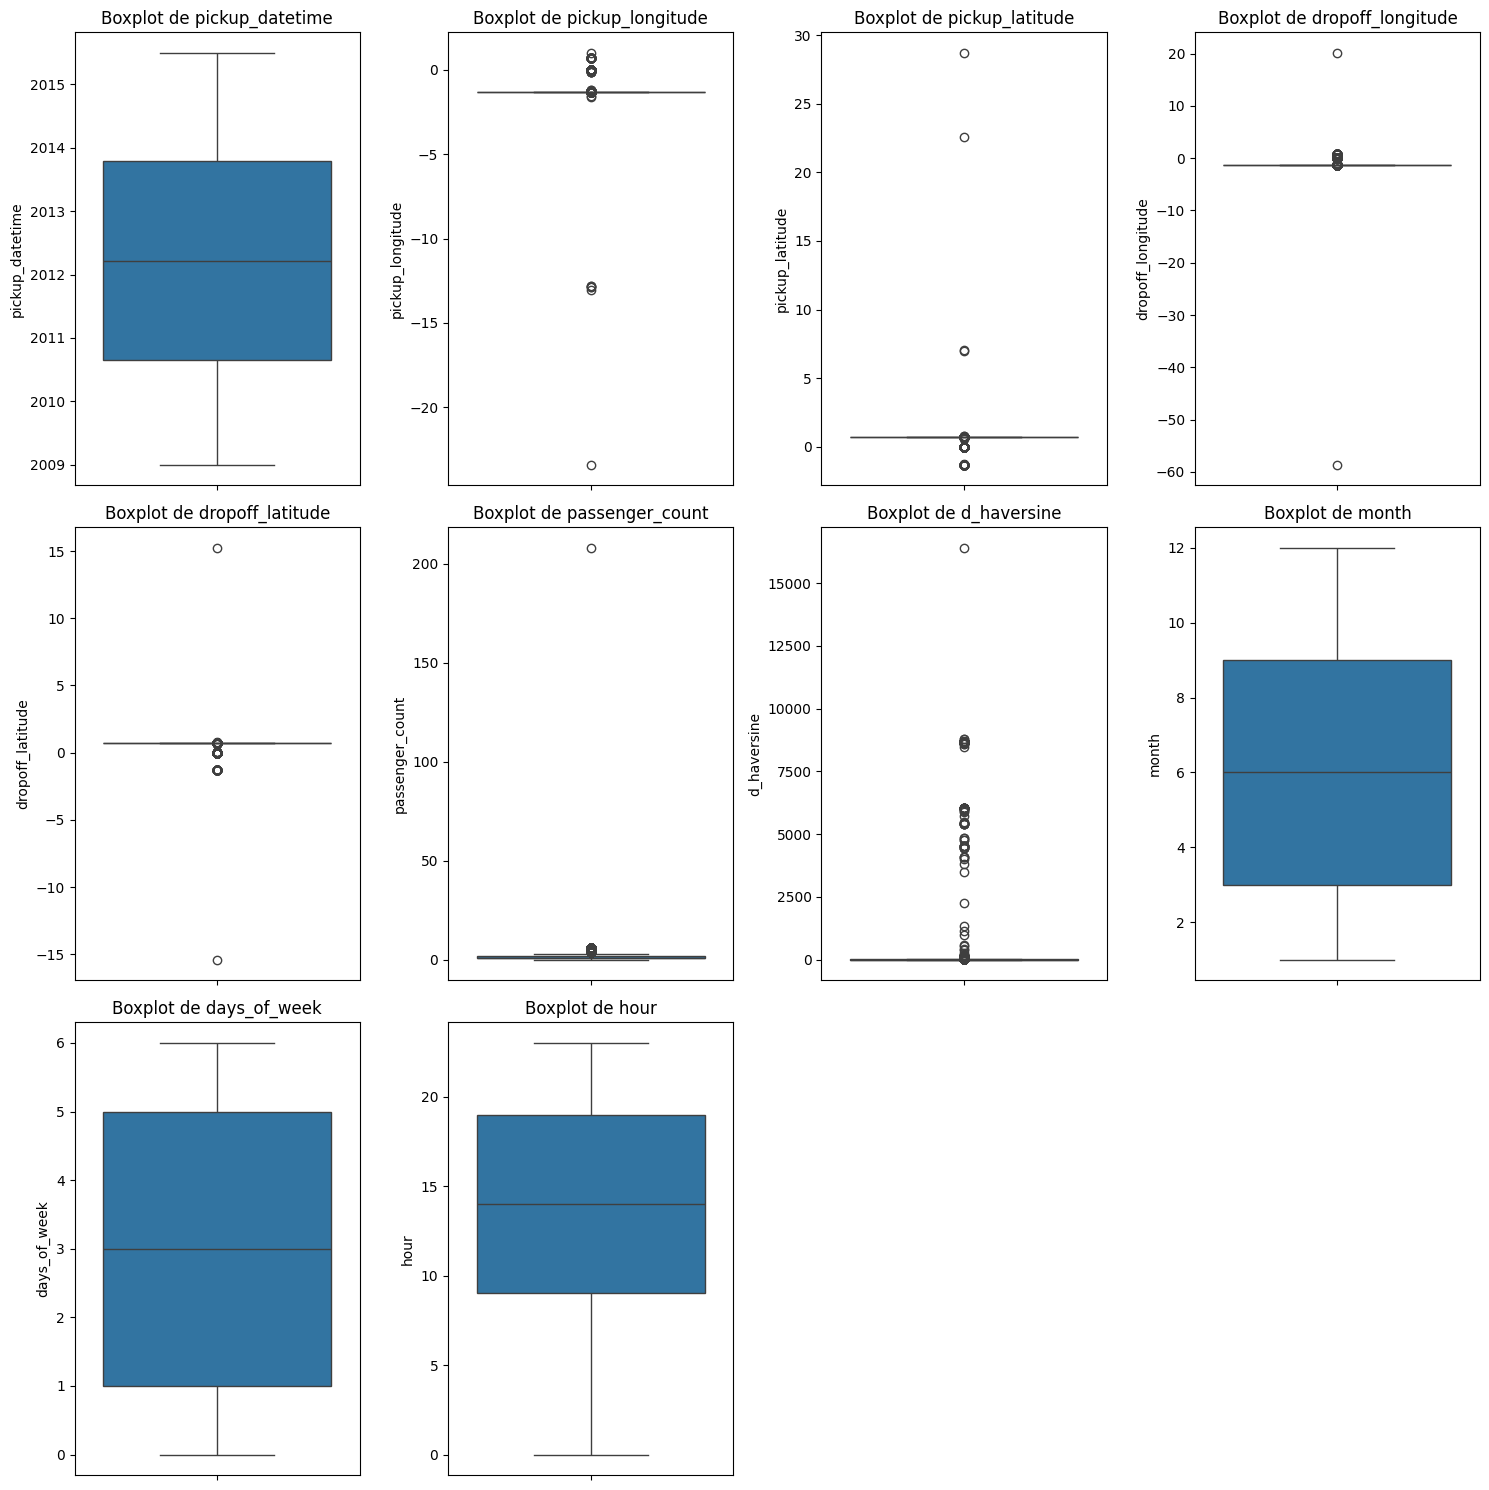

In [90]:
# Boxplot de las features
   
plt.figure(figsize=(15,15))
columnas = X_train.drop(columns=['key','date']).columns
for column in range(len(columnas)):
    plt.subplot(3, 4, column + 1)
    sns.boxplot(y=X_train[columnas[column]])
    plt.title(f'Boxplot de {columnas[column]}')
plt.tight_layout()
plt.show()

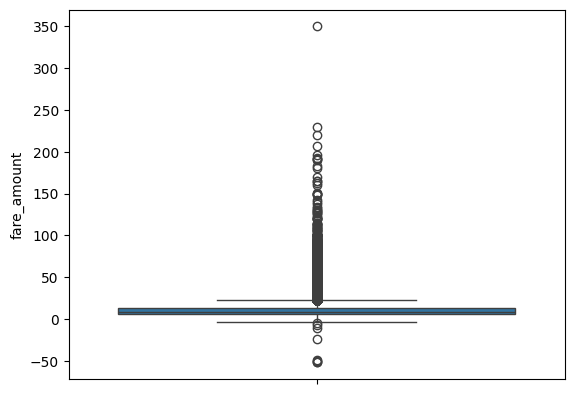

In [91]:
sns.boxplot(y_train)
plt.show()

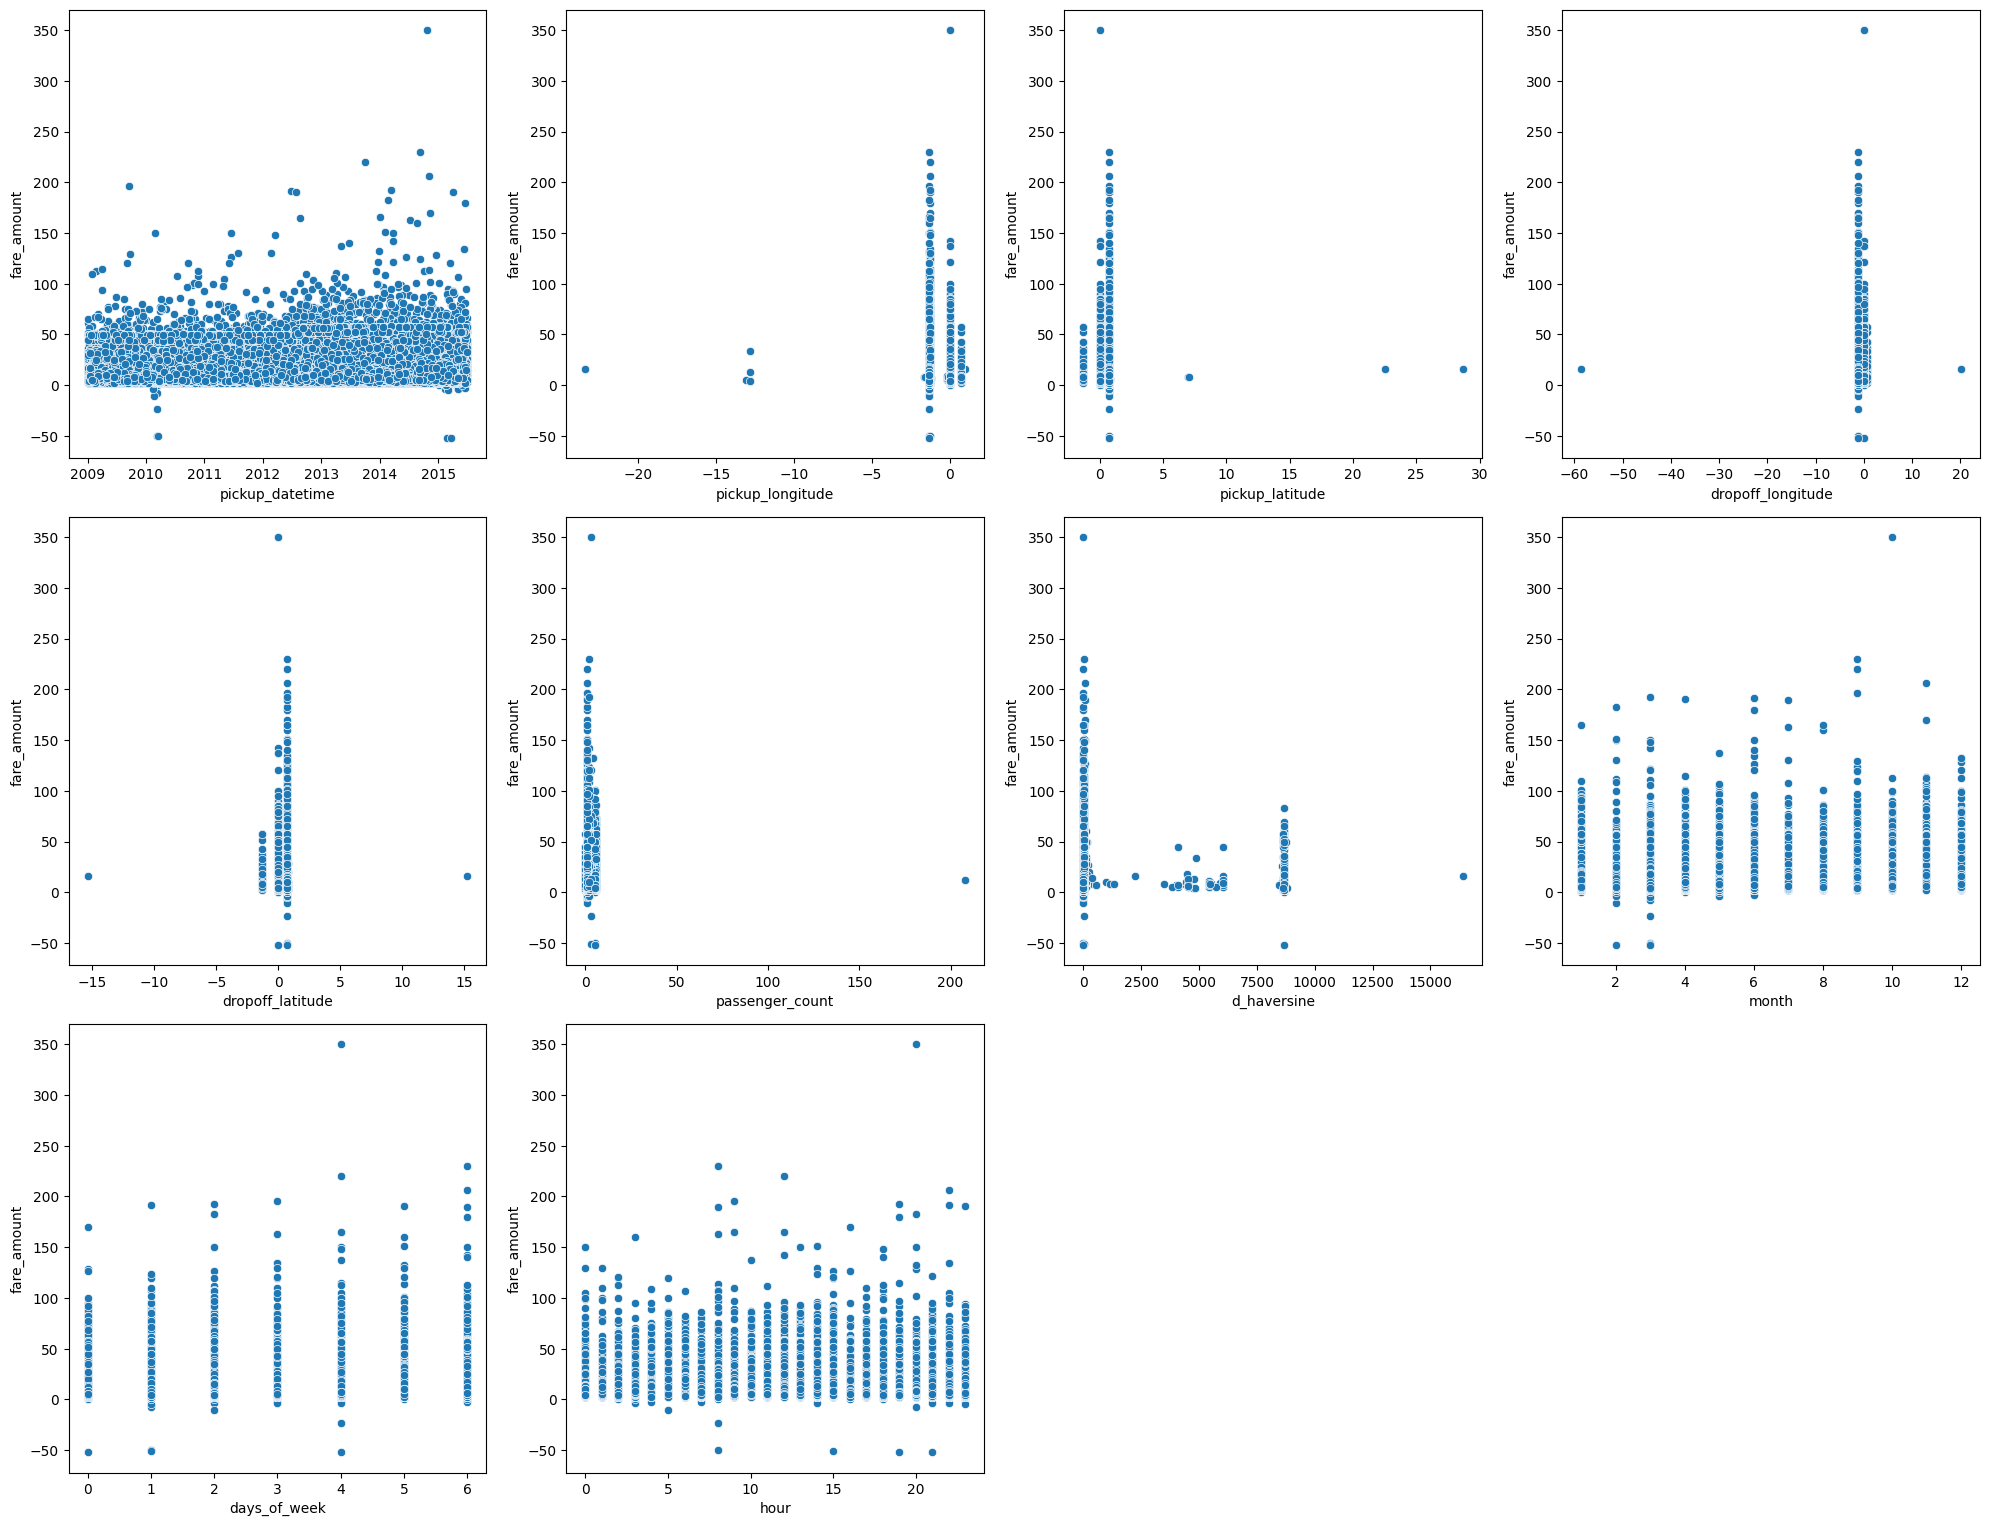

In [92]:
# Análisis de outliers respecto a fare_amount
columnas = X_train.drop(columns=['key','date']).columns

plt.figure(figsize=(20,20))

for column in range(len(columnas)):
    plt.subplot(4, 4, 1 + column)
    sns.scatterplot( x = X_train[columnas[column]], y = y_train)
plt.tight_layout()
plt.show()    

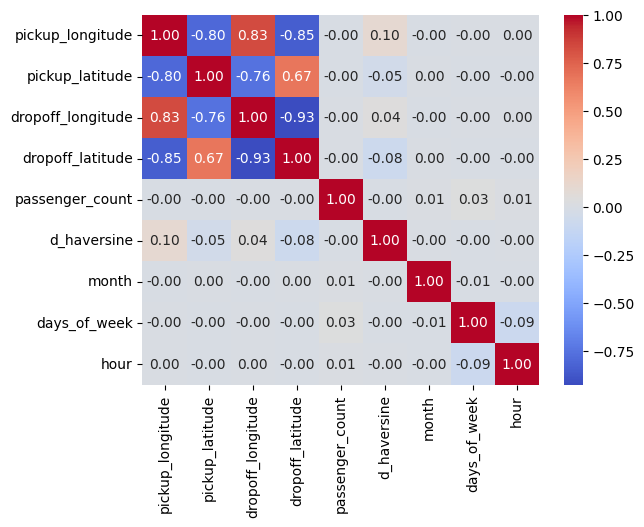

In [93]:
# Esto nos permite reducir dimensiones , esto justifica la creación de una nueva feature que represente la coordenadas (distancia)

sns.heatmap(X_train.drop(columns=['key','date','pickup_datetime']).corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.show()

### 5 - Tratamiento de valores atipicos y datos faltantes

In [94]:
print("Análisis de datos faltantes:")

missing_data = pd.DataFrame({
    'Valores faltantes' : X_train.isnull().sum(),
    'Porcentaje' : (X_train.isnull().sum() / len(df)) * 100})
print(missing_data)

Análisis de datos faltantes:
                   Valores faltantes  Porcentaje
key                                0      0.0000
date                               0      0.0000
pickup_datetime                    0      0.0000
pickup_longitude                   0      0.0000
pickup_latitude                    0      0.0000
dropoff_longitude                  1      0.0005
dropoff_latitude                   1      0.0005
passenger_count                    0      0.0000
d_haversine                        1      0.0005
month                              0      0.0000
days_of_week                       0      0.0000
hour                               0      0.0000


In [95]:
# Eliminamos la fila donde carecemos del valor de la distancia 
print(len(X_train))
print(len(X_train['d_haversine'].dropna))

160000


TypeError: object of type 'method' has no len()

In [ ]:
"""
# Calcular cuantiles (percentil 99)
q99_haversine = X_train['d_haversine'].quantile(0.99)
# q99_fare = df['fare_amount'].quantile(0.99)
q99_count_passanger =
# Calcular la mediana de cada columna
median_haversine = df['d_haversine'].median()
median_fare = df['fare_amount'].median()

# Reemplazar valores atípicos por la mediana
df.loc[df['d_haversine'] > q99_haversine, 'd_haversine'] = median_haversine
df.loc[df['fare_amount'] > q99_fare, 'fare_amount'] = median_fare

"""

Visualización de distribuciones y detección de valores atípicos

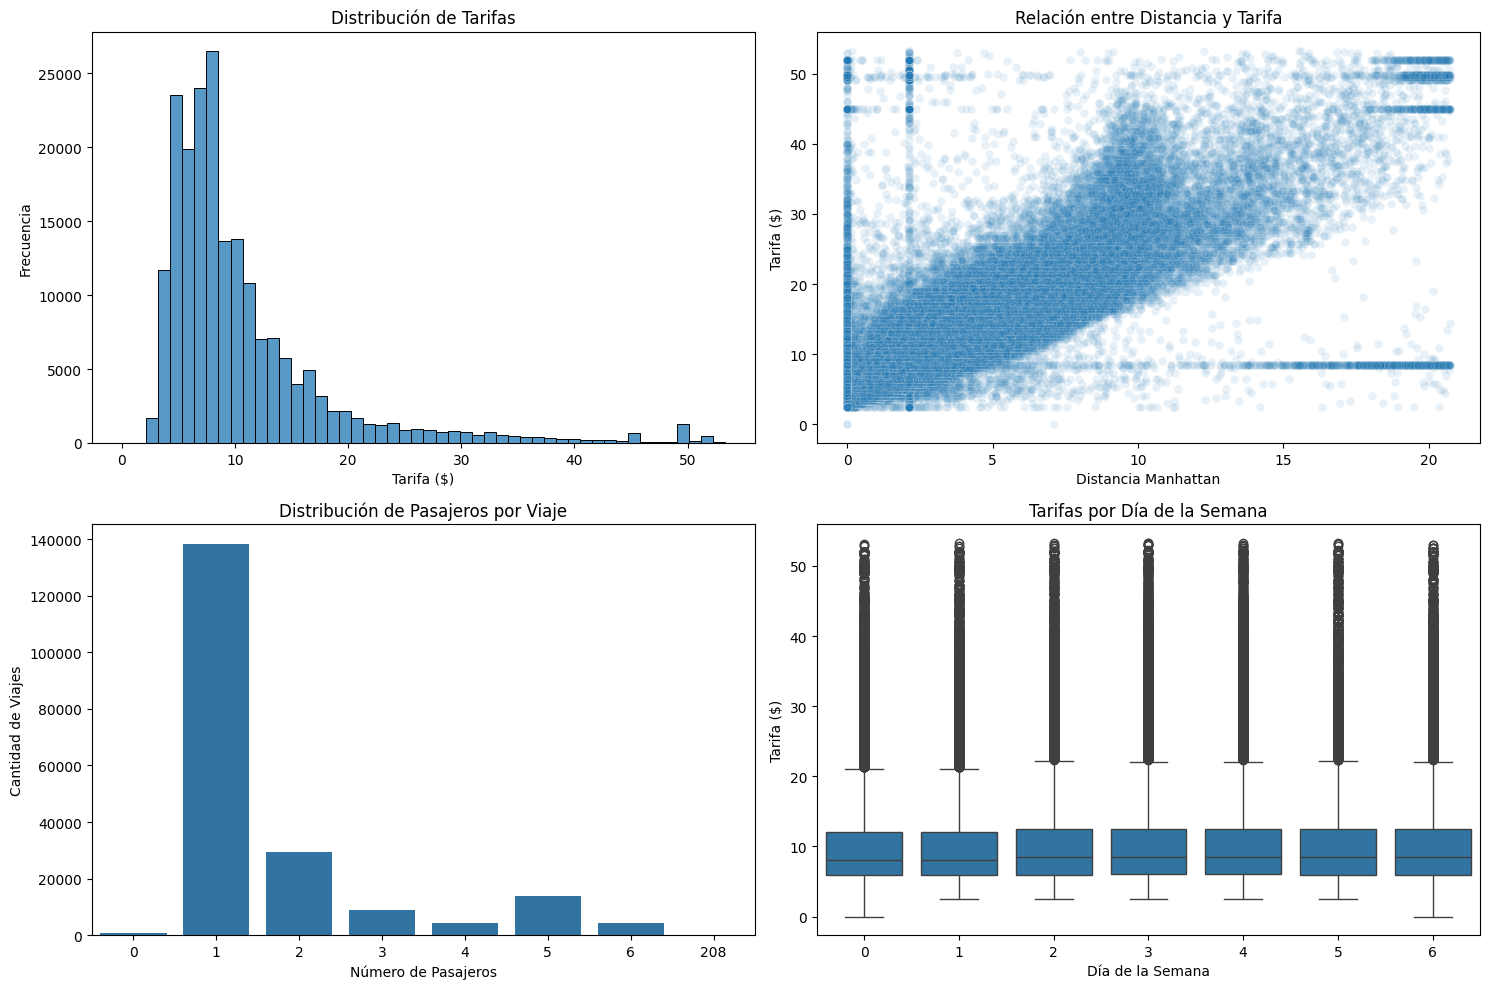

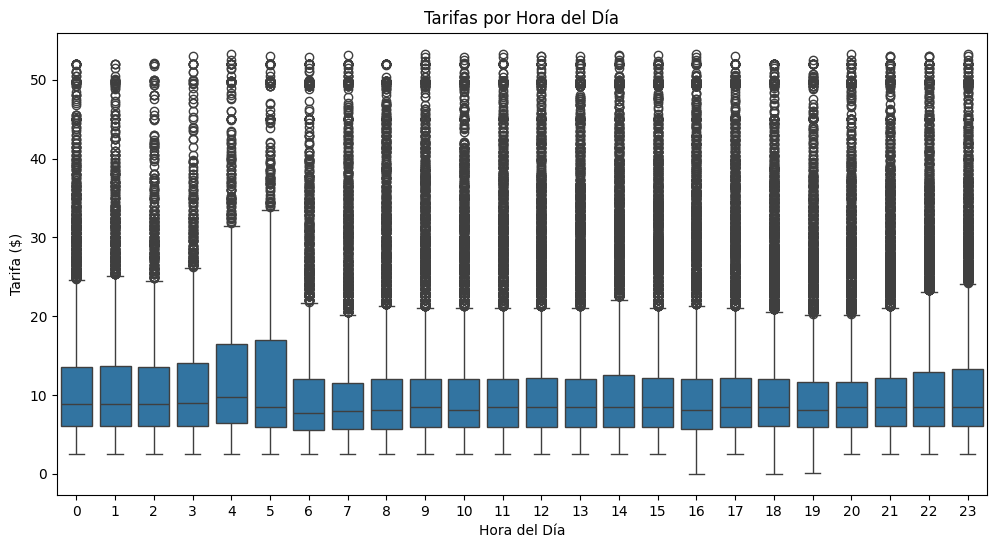

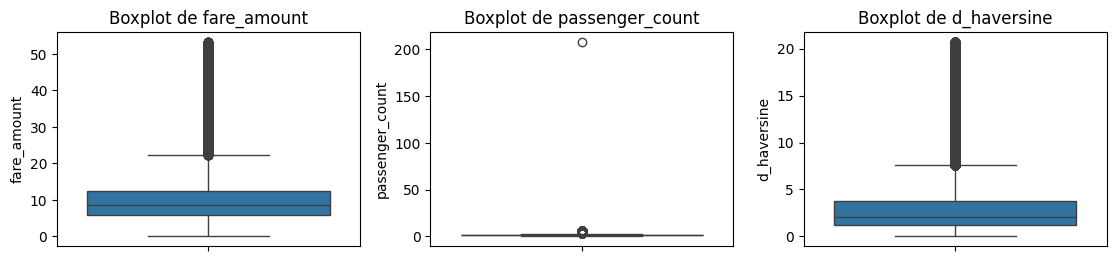

In [ ]:
### MAL , esto hay que hacerlo distinto, usar X_train. Ver la posibilidad de realizar un pairplot para hacer scatterplot en todas las variables.


### Se podria introducir el uso de mi variable target pero siempre y cuando usemos y_test. Para hacer scatterplot


# 1. Panel de visualizaciones principales
fig = plt.figure(figsize=(15, 10))

# Distribución de tarifas
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='fare_amount', bins=50)
plt.title('Distribución de Tarifas')
plt.xlabel('Tarifa ($)')
plt.ylabel('Frecuencia')

# Relación entre distancia y tarifa
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='d_haversine', y='fare_amount', alpha=0.1)
plt.title('Relación entre Distancia y Tarifa')
plt.xlabel('Distancia Manhattan')
plt.ylabel('Tarifa ($)')

# Distribución de pasajeros
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='passenger_count')
plt.title('Distribución de Pasajeros por Viaje')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Cantidad de Viajes')

# Tarifas por día de la semana
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='days_of_week', y='fare_amount')
plt.title('Tarifas por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Tarifa ($)')

plt.tight_layout()
plt.show()

# 2. Análisis temporal
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='fare_amount')
plt.title('Tarifas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Tarifa ($)')
plt.show()

# 3. Matriz de correlación
numeric_columns = ['fare_amount',                                                     
'passenger_count',                
'd_haversine']

# 4. Análisis de valores atípicos
plt.figure(figsize=(15, 5))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
plt.tight_layout()
plt.show()